# **Predicting Movie Reviews Using Social Media Sentiment**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import string
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
text = pd.read_csv('/content/drive/MyDrive/Train.csv')

In [41]:
text.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [42]:
text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [43]:
text.describe().T

,count,mean,std,min,25%,50%,75%,max
label,40000.0,0.499525,0.500006,0.0,0.0,0.0,1.0,1.0


In [44]:
text["label"].value_counts()

0    20019
1    19981
Name: label, dtype: int64

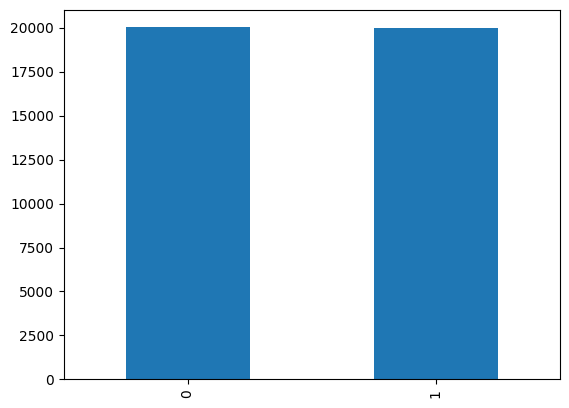

In [45]:
text["label"].value_counts().plot.bar()
plt.show()


it's clear that our data is pretty much balance

In [46]:
import nltk
nltk.download('stopwords')

def cleaning (text):
    text = text.lower()
    text =  re.sub(r'@\S+', '',text)  # remove twitter handles
    text =  re.sub(r'http\S+', '',text) # remove urls
    text =  re.sub(r'pic.\S+', '',text)
    text =  re.sub(r"[^a-zA-ZáéíóúÁÉÍÓÚ']", ' ',text) # only keeps characters
    text =  re.sub(r'\s+[a-zA-ZáéíóúÁÉÍÓÚ]\s+', ' ', text+' ')  # keep words with length>1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords])
    text= re.sub("\s[\s]+", " ",text).strip()
    text= re.sub("\s[\s]+", " ",text).strip() # remove repeated/leading/trailing spaces
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
text["text"]=text["text"].apply(cleaning)

In [50]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')


def lemm(data):
    wordnet = WordNetLemmatizer()
    lemmanized = []
    for i in range(len(data)):
        lemmed = []
        words = word_tokenize(data['text'].iloc[i])
        for w in words:
            lemmed.append(wordnet.lemmatize(w))
        lemmanized.append(lemmed)

    data['lemmanized'] = lemmanized
    data['text'] = data['lemmanized'].apply(' '.join)
    data=data.drop("lemmanized",axis=1)
    return data

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [51]:
text=lemm(text)
text.head()

,text,label
0,grew watching loving thunderbird mate school w...,0
1,put movie dvd player sat coke chip expectation...,0
2,people know particular time past like feel nee...,0
3,even though great interest biblical movie bore...,0
4,im die hard dad army fan nothing ever change g...,1


In [52]:
test = pd.read_csv('/content/drive/MyDrive/Test.csv')

In [53]:
test["text"]=test["text"].apply(cleaning)
test=lemm(test)
test.head()

,text,label
0,always wrote series complete stink fest jim be...,0
1,st watched dir steve purcell ty mary kate ashl...,0
2,movie poorly written directed fell asleep minu...,0
3,interesting thing miryang secret sunshine acto...,1
4,first read berlin meer didnt expect much thoug...,0


In [54]:
tfid = TfidfVectorizer()
X_train = tfid.fit_transform(text["text"])
X_test = tfid.transform(test["text"])

In [55]:
y_train = text["label"]
y_test = test["label"]

Vectorization with TF-IDF

In [57]:
svd = TruncatedSVD(n_components=50)

# use fit_transform on our standardized training features
X_train_pca = svd.fit_transform(X_train)

# use transform on our standardized test features
X_test_pca = svd.transform(X_test)

# look at the new shape of the transformed matrices
print('Training features matrix is: ', X_train_pca.shape)
print('Test features matrix is: ', X_test_pca.shape)

Training features matrix is:  (40000, 50)
Test features matrix is:  (5000, 50)


Here i use PCA, it is use to reduce the high dimensionality of a TF-IDF-transformed text dataset

## **Logistic Regression**

In [59]:
lr = LogisticRegression()
lr.fit(X_train_pca,y_train)
preds = lr.predict(X_test_pca)
print(accuracy_score(preds,y_test))

0.8462


## **Support Vector Machine**

In [60]:
SVM = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train_pca, y_train)
preds = SVM.predict(X_test_pca)
print(accuracy_score(preds,y_test))

0.8452


In [63]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l1', 'l2'],  # Regularization penalty
    'solver': ['liblinear'],   # Solver for optimization problem

  }
grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, cv=5)

In [64]:
grid_search.fit(X_train_pca, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [65]:
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.8445750000000001
